In [1]:
import torch
# from torch.utils.data import DataLoader, Dataset
# from skmultilearn.model_selection import iterative_train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
# class ProtDataset(Dataset):
#     def __init__(self, x, y):
#         super(ProtDataset, self).__init__()
#         assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
#         self.x = x
#         self.y = y

#     def __len__(self):
#         return self.y.shape[0]

#     def __getitem__(self, index):
#         return self.x[index], self.y[index]

In [2]:
with open('d:\\year 4\\semester 1\\BT\\BT 4033\\prediction\\labels\\cc_terms_class_order.pkl', 'rb') as f:
    go_terms_order = pickle.load(f)

In [3]:
with open('d:\\year 4\\semester 1\\BT\\BT 4033\\prediction\\datasets\\cc_dataset.pkl', 'rb') as f:
    prior_dataset = pickle.load(f)

In [4]:
inputs = np.array([vect['vect'] for vect in prior_dataset.values()])
outputs = np.array([vect['enc_label'] for vect in prior_dataset.values()])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42, stratify=outputs, shuffle=True)

In [6]:
X_train.shape

(11002, 225)

In [7]:
y_train.shape

(11002, 76)

In [8]:
train_class_counts = np.sum(y_train == 1, axis=0)
  # Sum along rows for each class
classes = torch.arange(len(train_class_counts))  # Class indices

In [9]:
print(train_class_counts)

[ 128  316  436  292  456   60   60 2576  316  316  140  368 1624 1604
 1048  204  204  128  228  184   72  364 1220 1688 2614  212   64 1152
  152  464   72  380  664  212  716  220  160  212   72   72  428  180
  228   64  352  244  312  332   64  212  376  464   56  192  316   80
  184  376 1292   72  184  192  316  180  248 1292  504  184  412   64
  104   48  272  184   80 2362]


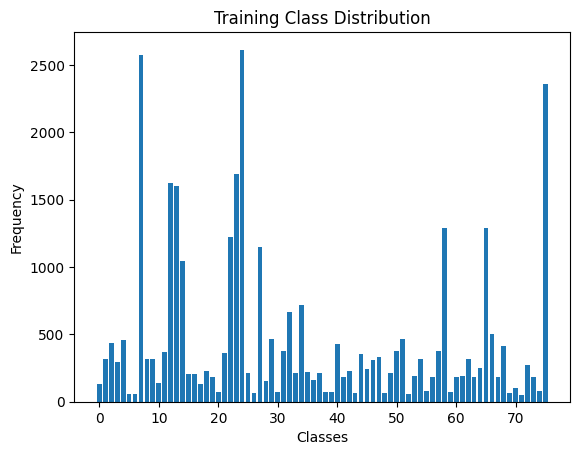

In [10]:
plt.bar(classes, train_class_counts)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Training Class Distribution')
plt.show()

In [11]:
class_weights = y_train.shape[0]/(train_class_counts)    # from deep fri 

In [12]:
weight_tensor = torch.tensor(class_weights)

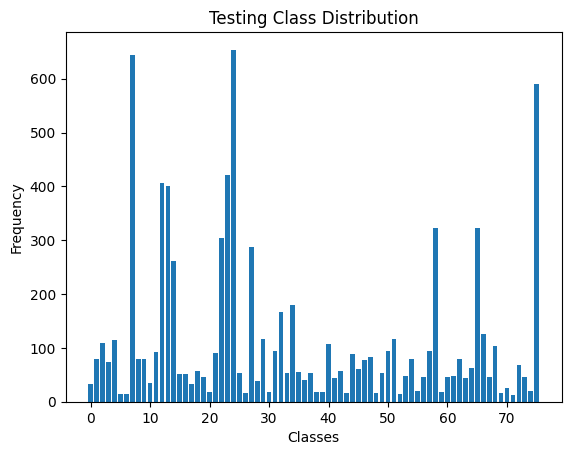

In [13]:
test_class_counts = np.sum(y_test == 1, axis=0)
plt.bar(classes, test_class_counts)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Testing Class Distribution')
plt.show()

In [13]:
# Define the model
class CC_PredictorModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(CC_PredictorModel, self).__init__()
        self.input_layer = nn.Linear(input_size, input_size)
        # self.middle_layer = nn.Linear(input_size, input_size)
        self.output_layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.input_layer(x).relu()
        # x = self.middle_layer(x).relu()
        
        x = self.output_layer(x)
        return x

In [14]:
model = CC_PredictorModel(225, 76)

In [15]:
# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight= weight_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
import matplotlib.pyplot as plt

# Lists to store accuracy values for plotting
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

In [23]:
def calculate_accuracy(predictions, labels, threshold=0.5):
    """
    Calculate multi-label accuracy.
    - predictions: Model outputs (probabilities after sigmoid).
    - labels: Ground truth labels.
    - threshold: Threshold to convert probabilities to binary labels (default 0.5).
    """
    # Apply threshold to convert probabilities to binary predictions
    predicted_labels = (predictions > threshold).float()
    
    # Correct predictions (element-wise match)
    correct = (predicted_labels == labels).float()
    
    # Accuracy is the average of correctly predicted labels
    accuracy = correct.mean().item()
    return accuracy

In [24]:
def train_model(model, inputs, labels, criterion, optimizer):
    model.train()  # Set model to training mode

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute loss
    loss = criterion(outputs, labels)
    train_losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    probabilities = outputs.sigmoid()  # Convert logits to probabilities
    accuracy = calculate_accuracy(probabilities, labels)
    train_accuracies.append(accuracy)
    # Return the loss
    return loss.item(), accuracy 


# Testing function without batching
def test_model(model, inputs, labels, criterion):
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for testing
        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

    # Apply sigmoid to outputs for multi-label probabilities
    probabilities = outputs.sigmoid()
    accuracy = calculate_accuracy(probabilities, labels)
    test_accuracies.append(accuracy)

    # Return the loss and predictions
    return loss.item(), accuracy

In [25]:
minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
minmax_scaled_train_data = torch.from_numpy(minmax_scaler.fit_transform(X_train)).float()

In [26]:
minmax_scaled_test_data = torch.from_numpy(minmax_scaler.transform(X_test)).float()

In [27]:
train_label = torch.from_numpy(y_train).float()
                               
test_label = torch.from_numpy(y_test).float()

In [30]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Train
    train_loss, train_accuracy = train_model(model, minmax_scaled_train_data, train_label, criterion, optimizer)

    # Test (optional: use a separate test dataset)
    test_loss, test_accuracy = test_model(model, minmax_scaled_test_data, test_label, criterion)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/100, Train Loss: 0.0690, Train Accuracy: 0.9850, Test Loss: 0.0719, Test Accuracy: 0.9847
Epoch 2/100, Train Loss: 0.0688, Train Accuracy: 0.9850, Test Loss: 0.0716, Test Accuracy: 0.9848
Epoch 3/100, Train Loss: 0.0686, Train Accuracy: 0.9850, Test Loss: 0.0714, Test Accuracy: 0.9848
Epoch 4/100, Train Loss: 0.0684, Train Accuracy: 0.9851, Test Loss: 0.0712, Test Accuracy: 0.9849
Epoch 5/100, Train Loss: 0.0681, Train Accuracy: 0.9851, Test Loss: 0.0709, Test Accuracy: 0.9849
Epoch 6/100, Train Loss: 0.0679, Train Accuracy: 0.9851, Test Loss: 0.0707, Test Accuracy: 0.9849
Epoch 7/100, Train Loss: 0.0677, Train Accuracy: 0.9852, Test Loss: 0.0705, Test Accuracy: 0.9850
Epoch 8/100, Train Loss: 0.0675, Train Accuracy: 0.9852, Test Loss: 0.0703, Test Accuracy: 0.9850
Epoch 9/100, Train Loss: 0.0672, Train Accuracy: 0.9853, Test Loss: 0.0700, Test Accuracy: 0.9850
Epoch 10/100, Train Loss: 0.0670, Train Accuracy: 0.9853, Test Loss: 0.0698, Test Accuracy: 0.9850
Epoch 11/100, Train

In [46]:
torch.save(model.state_dict(), 'bp_predictor_final.pt')

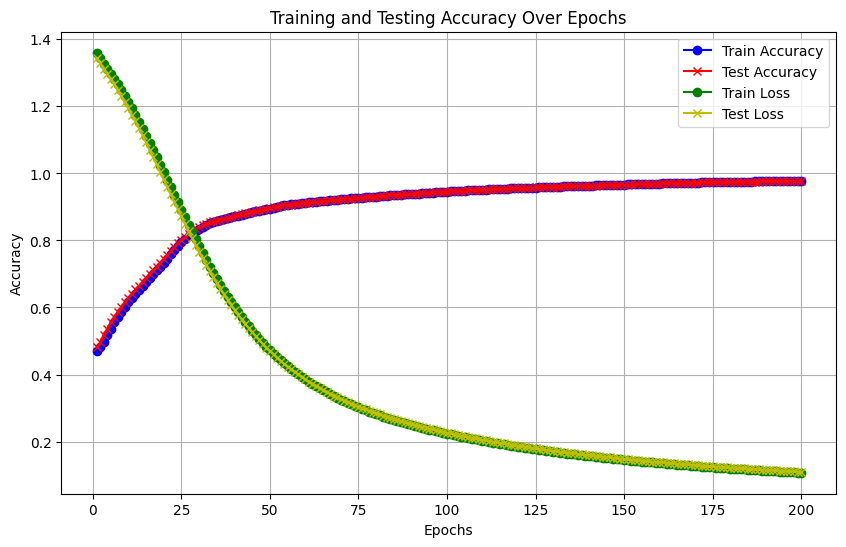

In [44]:
# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='b', linestyle='-', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='r', linestyle='-', marker='x')

plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='g', linestyle='-', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='y', linestyle='-', marker='x')

plt.title('Training and Testing Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
true_labels = y_test.astype(int)

model.eval()
with torch.no_grad():
    # Forward pass to get model predictions
    outputs = model(minmax_scaled_test_data).sigmoid().numpy()
predicted_labels = (outputs > 0.5).astype(int)

c:\Users\sachintha\anaconda3\envs\ppi_dl\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


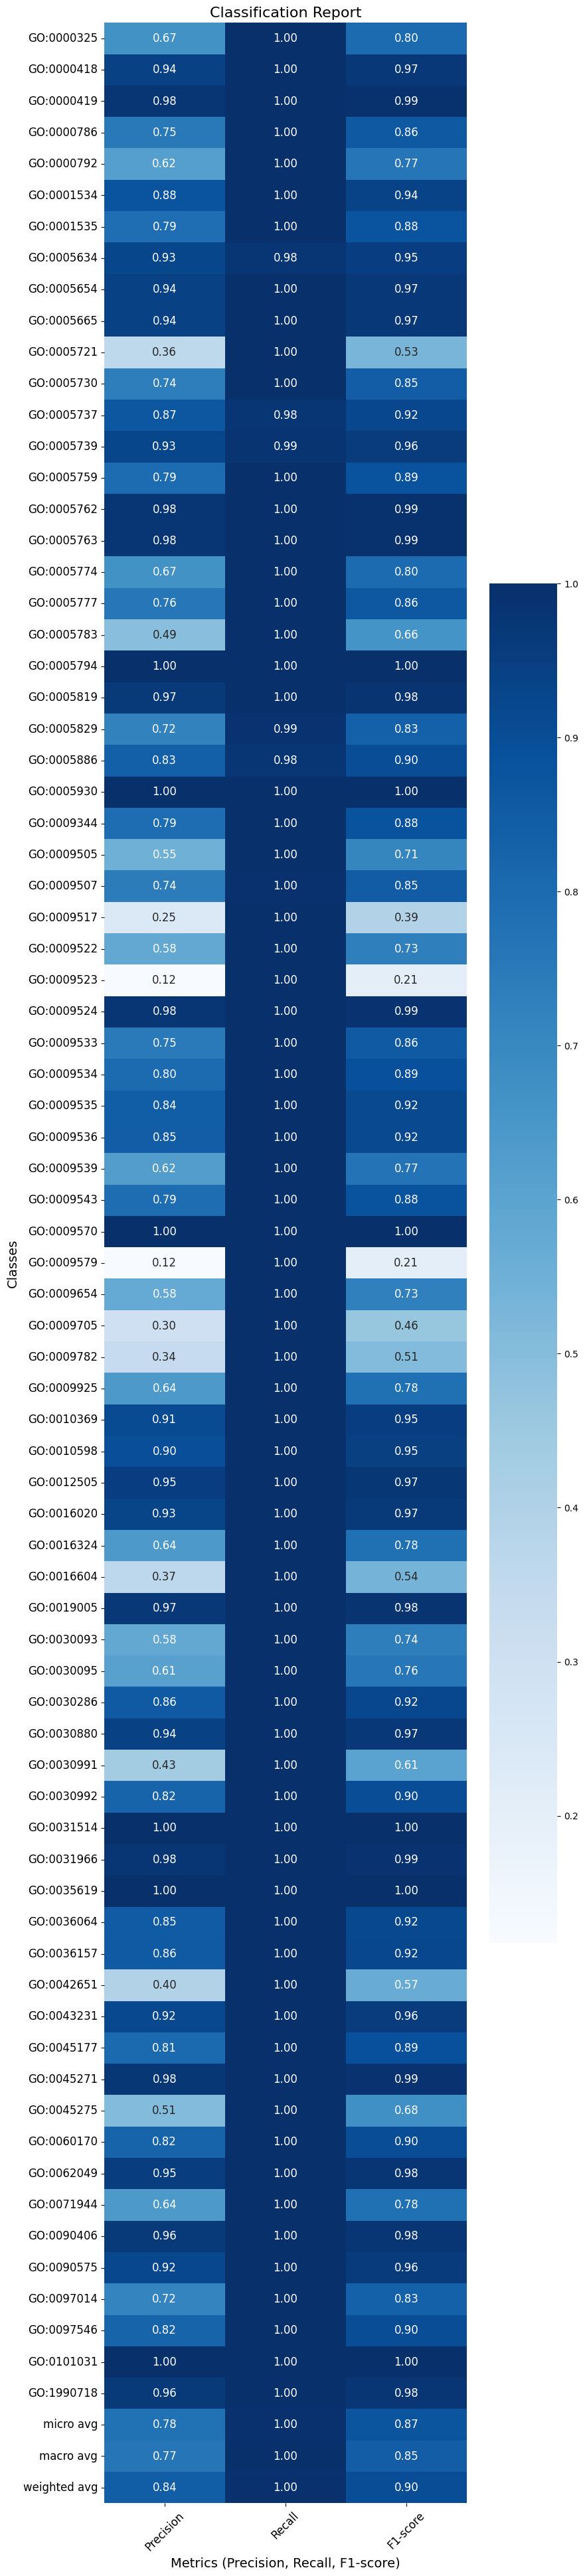

In [32]:
from sklearn.metrics import classification_report
cr = classification_report(true_labels, predicted_labels, output_dict= True, target_names= go_terms_order)
report_df = pd.DataFrame(cr).transpose()
# Plot the classification report as a heatmap
plt.figure(figsize=(10, 40))  # Increased figure size for better spacing
sns.heatmap(report_df.iloc[:-1, :-1].astype(float), annot=True, cmap="Blues", fmt='.2f', cbar=True, 
            annot_kws={"size": 12})  # Increase the size of the annotation text

# Customize the plot for better visibility
plt.title("Classification Report", fontsize=16)
plt.ylabel("Classes", fontsize=14)
plt.xlabel("Metrics (Precision, Recall, F1-score)", fontsize=14)
plt.xticks(np.arange(3) + 0.5, ['Precision', 'Recall', 'F1-score'], rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)  # Increase font size for y-axis labels

# Adjust layout to avoid overlapping
plt.tight_layout(pad=5)  # Increase padding between plot elements

# Show the plot
plt.show()

Overall ROC AUC: 1.00


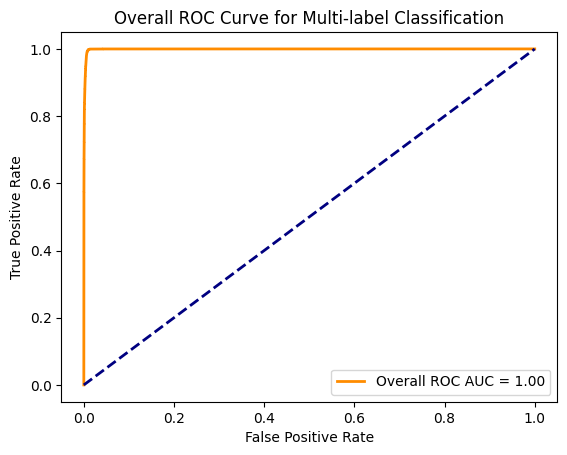

In [53]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
# To calculate the overall ROC curve across all labels
# Flatten the labels and predictions for combined ROC
y_true_flat = true_labels.ravel()
y_pred_flat = outputs.ravel()

fpr_all, tpr_all, _ = roc_curve(y_true_flat, y_pred_flat)
roc_auc_all = auc(fpr_all, tpr_all)

print(f"Overall ROC AUC: {roc_auc_all:.2f}")

# Plot combined ROC
plt.figure()
plt.plot(fpr_all, tpr_all, color='darkorange', lw=2, label=f'Overall ROC AUC = {roc_auc_all:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve for Multi-label Classification')
plt.legend(loc="lower right")
plt.show()

Overall PR AUC: 0.98


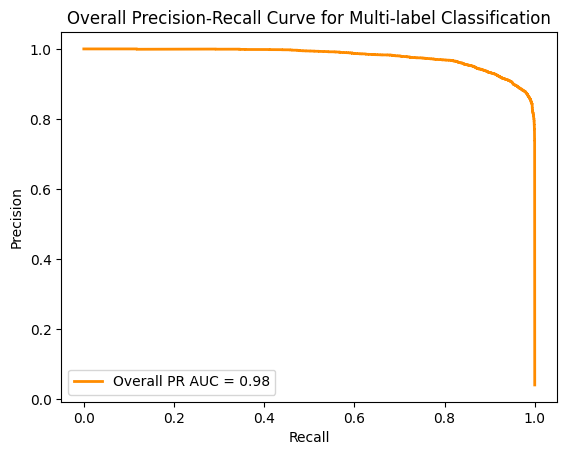

In [54]:
precision_all, recall_all, _ = precision_recall_curve(y_true_flat, y_pred_flat)
pr_auc_all = auc(recall_all, precision_all)

print(f"Overall PR AUC: {pr_auc_all:.2f}")

# Plot combined PR curve
plt.figure()
plt.plot(recall_all, precision_all, color='darkorange', lw=2, label=f'Overall PR AUC = {pr_auc_all:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Overall Precision-Recall Curve for Multi-label Classification')
plt.legend(loc="lower left")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
# Calculate AUROC and AUPR for each label
roc_auc_values = []
pr_auc_values = []
fprs, tprs, precisions, recalls = [], [], [], []

for i in range(120):
    fpr, tpr, _ = roc_curve(true_labels[:, i], outputs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)
    fprs.append(fpr)
    tprs.append(tpr)

    precision, recall, _ = precision_recall_curve(true_labels[:, i], outputs[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)
    precisions.append(precision)
    recalls.append(recall)

# Macro AUROC and AUPR
macro_roc_auc = np.mean(roc_auc_values)
macro_pr_auc = np.mean(pr_auc_values)

# Micro AUROC and AUPR
fpr_micro, tpr_micro, _ = roc_curve(true_labels.ravel(), outputs.ravel())
micro_roc_auc = auc(fpr_micro, tpr_micro)

precision_micro, recall_micro, _ = precision_recall_curve(true_labels.ravel(), outputs.ravel())
micro_pr_auc = auc(recall_micro, precision_micro)

# Plot AUROC and AUPR Violin Plots
# auc_df = pd.DataFrame({
#     'Metric': ['ROC AUC'] * len(roc_auc_values) + ['PR AUC'] * len(pr_auc_values),
#     'Value': roc_auc_values + pr_auc_values
# })

# plt.figure(figsize=(12, 6))
# sns.violinplot(x='Metric', y='Value', data=auc_df)
# plt.title('Distribution of AUROC and AUPR')
# # plt.savefig('auroc_aupr_violin_plot.png')
# plt.show()

# Plot ROC and PR Curves
plt.figure(figsize=(12, 6))

# Plot ROC Curves
plt.subplot(1, 2, 1)
for i in range(120):
    plt.plot(fprs[i], tprs[i], label=f'Label {i} (AUC = {roc_auc_values[i]:.2f})')
plt.plot(fpr_micro, tpr_micro, label=f'Micro Average (AUC = {micro_roc_auc:.2f})', linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Macro AUC = {macro_roc_auc:.2f})')
# plt.legend(loc='best')

# Plot PR Curves
plt.subplot(1, 2, 2)
for i in range(120):
    plt.plot(recalls[i], precisions[i], label=f'Label {i} (AUC = {pr_auc_values[i]:.2f})')
plt.plot(recall_micro, precision_micro, label=f'Micro Average (AUC = {micro_pr_auc:.2f})', linestyle='--', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (Macro AUC = {macro_pr_auc:.2f})')
# plt.legend(loc='best')

plt.tight_layout()
# plt.savefig('roc_pr_curves.png')
plt.show()

# Compute Confusion Matrix: Calculate TP, FP, TN, FN for each label and sum them
TP, FP, TN, FN = 0, 0, 0, 0
for i in range(120):
    predicted = (true_labels[:, i] >= 0.5).astype(int)
    actual = true_labels[:, i]
    
    tp = np.sum((predicted == 1) & (actual == 1), axis=0)
    fp = np.sum((predicted == 1) & (actual == 0), axis=0)
    tn = np.sum((predicted == 0) & (actual == 0), axis=0)
    fn = np.sum((predicted == 0) & (actual == 1), axis=0)

    TP += tp
    FP += fp
    TN += tn
    FN += fn

# Final aggregated confusion matrix
conf_matrix = np.array([[TP, FP], [FN, TN]])

# Plot aggregated confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Positive', 'Negative'])
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
# plt.savefig('confusion_matrix.png')
plt.show()

In [33]:
# Number of classes (columns)
num_classes = true_labels.shape[1]

# Initialize a dictionary to store the metrics for each class
metrics_per_class = {}

In [34]:
# Iterate over each class (column)
for class_idx in range(num_classes):
    y_true = true_labels[:, class_idx]
    y_pred = predicted_labels[:, class_idx]
    
    # Calculate TP, TN, FP, FN
    tp = np.sum((y_true == 1) & (y_pred == 1), axis=0)
    tn = np.sum((y_true == 0) & (y_pred == 0), axis=0)
    fp = np.sum((y_true == 0) & (y_pred == 1), axis=0)
    fn = np.sum((y_true == 1) & (y_pred == 0), axis=0)
    
    # Store the results in the dictionary
    metrics_per_class[f'Class {class_idx}'] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    }

In [35]:
metrics_df = pd.DataFrame(metrics_per_class).T
metrics_df.head()

,TP,TN,FP,FN
Class 0,32,2703,16,0
Class 1,79,2667,5,0
Class 2,109,2640,2,0
Class 3,73,2654,24,0
Class 4,114,2567,70,0


In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [37]:
# Function to plot confusion matrices for each class
def plot_confusion_matrices(metrics_df, per_row=4):
    num_classes = len(metrics_df)
    rows = (num_classes + per_row - 1) // per_row  # Calculate required rows
    
    fig, axes = plt.subplots(rows, per_row, figsize=(5 * per_row, 5 * rows))
    axes = axes.flatten()  # Flatten axes for easy iteration
    
    for idx, (class_name, metrics) in enumerate(metrics_df.iterrows()):
        # Extract confusion matrix values
        tp, fn, fp, tn = metrics['TP'], metrics['FN'], metrics['FP'], metrics['TN']
        confusion_matrix = np.array([[tp, fn], [fp, tn]])  # Arrange elements accordingly
        
        # Plot using sklearn
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Positive', 'Negative'])
        disp.plot(cmap=plt.cm.Blues, ax=axes[idx])
        axes[idx].set_title(f"Confusion Matrix for {class_name}")
    
    # Hide any unused subplots
    for idx in range(len(metrics_df), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

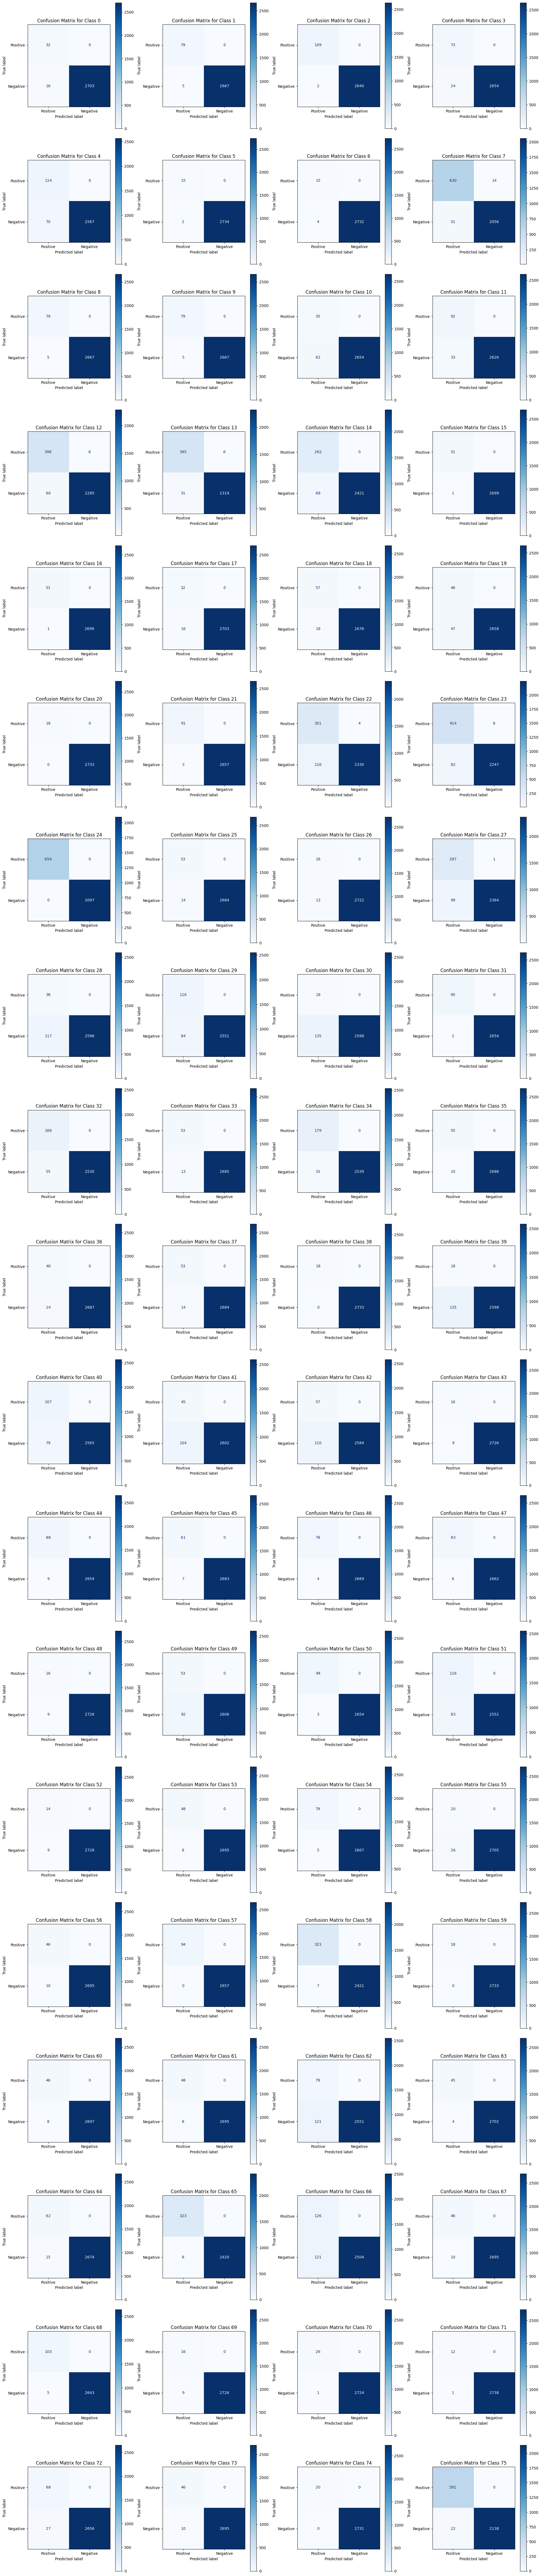

In [38]:
plot_confusion_matrices(metrics_df, per_row=4)